In [126]:
#Samuel A
#This project is going to try to classify the paintings of Titian, Pablo Piccasso and Vincent van Gogh
#Using transfer learning 

import os
import time
import random
from PIL import Image as PImage
import numpy as np # linear algebra
from numpy import asarray
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, BatchNormalization, Activation
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score
import gc

gc.collect()

562

In [95]:
#Artists classes
a=['titian','picasso','gogh']
a_encoded = [0,1,2]

titian_images = []
titian_labels = []

picasso_images = []
picasso_labels = []

gogh_images = []
gogh_labels = []

input_shape = (200,200,3)

#number of classes
classes = len(a_encoded)

In [96]:
#Show image count
def show_image_count(t,p,v):
    print('tit_ttl: ' + str(t))
    print('picc_ttl: ' + str(p))
    print('gogh_ttl: ' + str(v))
    print('ttl: '+ str(t+p+v)+' images')
    
#Draw a picture   
def show_image(var):
    plt.imshow(var)
    plt.axis('Off')
    plt.show()

#Load images from path and convert to an array of pixels
def get_image(path,target_width,target_height):
    #img = PImage.open(path)
    img = load_img(path, target_size=(target_width,target_height))
    pixels = img_to_array(img)
    return pixels

#Save image to an array
def load_images_from_path(dirname,file,array,labels,label,target_width,target_height):
        path = os.path.join(dirname,file)
        img = get_image(path, target_width,target_height)
        array.append(img)
        labels.append(label)

In [97]:
#Load entire data from the 3 mentioned artists
def load_data():
    
    t,p,v = 0,0,0
    
    for dirname, _, filenames in os.walk('/kaggle/input/best-artworks-of-all-time/images/images/'):
        for filename in filenames:
            
            #path = os.path.join(dirname, filename)
            nfolder = dirname.split("/")
            folder = nfolder[len(nfolder)-1]
        
            #Titian
            if folder == 'Titian':
                load_images_from_path(dirname,filename,titian_images,titian_labels,a_encoded[0],200,200)
                t += 1
        
            #Pablo_Picasso
            if folder == 'Pablo_Picasso':
                load_images_from_path(dirname, filename, picasso_images, picasso_labels, a_encoded[1],200,200)
                p+= 1
        
            #Vincent_van_Gogh 
            if folder == 'Vincent_van_Gogh':
                load_images_from_path(dirname, filename, gogh_images, gogh_labels, a_encoded[2],200,200)
                v+= 1
        
    show_image_count(t,p,v)
    

In [98]:
#Plot a graph with data given
def plot_graph(train_loss_acc, val_loss_acc, title, y_label, x_label, legend):
    plt.plot(train_loss_acc)
    plt.plot(val_loss_acc)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.legend(legend, loc='upper left')
    plt.show()

#Show classification report
def show_classification_report(y_test, preds, names):
    print('\n')
    print('***** Classification Report*****')
    print(classification_report(y_test.argmax(axis=1), preds, target_names=names))
    
#Show confusion matrix
def show_confusion_matrix(y_test, preds):
    print('\n')
    print('***** Confusion Matrix *****')
    print(confusion_matrix(y_test.argmax(axis=1), preds))

In [99]:
#Load all the data
load_data()

tit_ttl: 255
picc_ttl: 439
gogh_ttl: 877
ttl: 1571 images


In [100]:
#Select training_data

train_titian_images = titian_images[20:200]
train_titian_labels = titian_labels[20:200]

train_picasso_images = picasso_images[20:200]
train_picasso_labels = picasso_labels[20:200]

train_gogh_images = gogh_images[20:200]
train_gogh_labels = gogh_labels[20:200]

#############################################################
#Select validation data

val_titian_images = titian_images[0:20]
val_titian_labels = titian_labels[0:20]

val_picasso_images = picasso_images[0:20]
val_picasso_labels = picasso_labels[0:20]

val_gogh_images = gogh_images[0:20]
val_gogh_labels = gogh_labels[0:20]

############################################################

#Join all images and labels
validation_images = val_titian_images + val_picasso_images + val_gogh_images
validation_labels = val_titian_labels + val_picasso_labels + val_gogh_labels
#####################################################################################

training_images = train_titian_images + train_picasso_images + train_gogh_images
training_labels = train_titian_labels + train_picasso_labels + train_gogh_labels

#####################################################################################

#Shuffle all the data
train_data = list(zip(training_images, training_labels))
random.shuffle(train_data)
training_images, training_labels = zip(*train_data)

val_data = list(zip(validation_images, validation_labels))
random.shuffle(val_data)
validation_images, validation_labels = zip(*val_data)

#Convert arrays to numpy arrays
training_images = asarray(training_images)
training_labels = asarray(training_labels)

validation_images = asarray(validation_images)
validation_labels = asarray(validation_labels)

print('train data shape: ', training_images.shape)
print('train label shape: ', training_labels.shape)
print('val data shape: ', validation_images.shape)
print('val label shape: ', validation_labels.shape)

train data shape:  (540, 200, 200, 3)
train label shape:  (540,)
val data shape:  (60, 200, 200, 3)
val label shape:  (60,)


In [101]:
#prepare testing data
test_titian_images = titian_images[200:]
test_titian_labels = titian_labels[200:]

test_picasso_images = picasso_images[200:255]
test_picasso_labels = picasso_labels[200:255]

test_gogh_images = gogh_images[200:255]
test_gogh_labels = gogh_labels[200:255]

test_images = test_titian_images + test_picasso_images + test_gogh_images
test_labels = test_titian_labels + test_picasso_labels + test_gogh_labels

test_data = list(zip(test_images, test_labels))
random.shuffle(test_data)
test_images, test_labels = zip(*test_data)

test_images = asarray(test_images)
test_labels = asarray(test_labels)

print('test data shape: ', test_images.shape)
print('test label shape: ', test_labels.shape)


test data shape:  (165, 200, 200, 3)
test label shape:  (165,)


In [102]:
# Convert values to float
training_images = training_images.astype('float32')
validation_images = validation_images.astype('float32')
test_images = test_images.astype('float32')

#One hot encode labels
training_labels = to_categorical(training_labels)
validation_labels = to_categorical(validation_labels)
test_labels = to_categorical(test_labels)

print(training_labels[0])

#Normalize data
training_images = training_images/255
validation_images = validation_images/255
test_images = test_images/255


[0. 0. 1.]


In [103]:
#######################################################
picasso_excess_images = picasso_images[255:]
picasso_excess_labels = picasso_labels[255:]

gogh_excess_images = gogh_images[255:]
gogh_excess_labels = gogh_labels[255:]
#--------------------------------------------------------

picasso_excess_images = asarray(picasso_excess_images)
gogh_excess_images = asarray(gogh_excess_images)

#----------------------------------------------------------

picasso_excess_images = picasso_excess_images.astype('float32')
gogh_excess_images = gogh_excess_images.astype('float32')

#--------------------------------------------------------

picasso_excess_labels = to_categorical(picasso_excess_labels)
gogh_excess_labels = to_categorical(gogh_excess_labels)

#-----------------------------------------------------------

picasso_excess_images = picasso_excess_images/255
gogh_excess_images = gogh_excess_images/255

#------------------------------------------------------------


#something to play around with later
#######################################################


In [104]:
print('train_data_shape: ', training_images.shape)
print('val_data_shape: ', validation_images.shape)

print('train_label_shape: ',training_labels.shape)
print('val_label_shape: ',validation_labels.shape)


train_data_shape:  (540, 200, 200, 3)
val_data_shape:  (60, 200, 200, 3)
train_label_shape:  (540, 3)
val_label_shape:  (60, 3)


In [105]:
#Augment the train data
train_image_generator = ImageDataGenerator(
    rotation_range = 30,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    vertical_flip = True,
    fill_mode = 'nearest'
)

#Augment the train data
val_image_generator = ImageDataGenerator(
    rotation_range = 30,
    horizontal_flip = True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    vertical_flip = True,
    fill_mode = 'nearest'
)

test_image_generator = ImageDataGenerator()

train_generator = train_image_generator.flow(training_images, training_labels)
val_generator = val_image_generator.flow(validation_images, validation_labels)
test_generator = test_image_generator.flow(test_images, test_labels)

In [106]:
#Transfer learning using the InceptionResNetV2

from tensorflow.keras.applications import InceptionResNetV2, Xception

In [107]:
base = InceptionResNetV2(weights='imagenet', include_top = False, input_shape=input_shape)

In [108]:
#create callbacks for earlystopping and modelcheckpoint so we stop training at the right time and save the best model
#after training.. we monitor the validation loss and stop training when it is at its minimum

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
mc = ModelCheckpoint('/kaggle/working/paintclf.h5', monitor='val_loss', mode='min', save_best_only=True)
callbacks = [es,mc]

In [109]:
#Summary of the InceptionResNetV2 model
#base.summary()
#Enable TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


In [127]:
#hyper parameters
epochs = 2000
batch_size=128

#Disable training for inception, bc we want to train just our added layers
base.trainable = False

#Define our a new model with Inception as our convolutional base and start training
# with tpu_strategy.scope():
model = models.Sequential()
model.add(base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(layers.Dense(classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

start = time.time()
print('Training started')

history = model.fit_generator(train_generator,
                              steps_per_epoch=(len(training_images)//32),
                              validation_data=val_generator,
                              validation_steps = (len(validation_images)//32),
                              callbacks=callbacks,
                              epochs=epochs, 
                              verbose=1)

end = time.time() - start
print('Training done, ET: '+str(end)+'s')

Training started
Epoch 1/2000
16/16 [==============================] - 18s 1s/step - loss: 7.7385 - accuracy: 0.4350 - val_loss: 6.1945 - val_accuracy: 0.6562
Epoch 2/2000
16/16 [==============================] - 20s 1s/step - loss: 4.4893 - accuracy: 0.6457 - val_loss: 3.9904 - val_accuracy: 0.7812
Epoch 3/2000
16/16 [==============================] - 19s 1s/step - loss: 3.3456 - accuracy: 0.6621 - val_loss: 2.7490 - val_accuracy: 0.8438
Epoch 4/2000
16/16 [==============================] - 19s 1s/step - loss: 2.6268 - accuracy: 0.7480 - val_loss: 2.5883 - val_accuracy: 0.8125
Epoch 5/2000
16/16 [==============================] - 18s 1s/step - loss: 2.2042 - accuracy: 0.7441 - val_loss: 2.6511 - val_accuracy: 0.7812
Epoch 00005: early stopping
Training done, ET: 94.76443290710449s


In [128]:
#Evaluate model and show accuracy
n_eval = model.evaluate(test_images, test_labels, steps=(len(test_images//32)), verbose=0)
print("Model Accuracy: ", round((n_eval[1]*100),2))

Model Accuracy:  75.15


In [112]:
#Save our model
# model2.save('/kaggle/working/incp'+str(n_eval[1])+'.h5')

In [130]:
# Make predictions
test_generator.reset()
steps = (test_generator.n//test_generator.batch_size)
n_preds = model.predict(test_images, verbose=0)
n_preds = np.argmax(n_preds, axis=1)

decoded_one_hot_labels = np.argmax(test_labels, axis=1)


# print(n_preds)
f1 = f1_score(decoded_one_hot_labels, n_preds, labels=None, pos_label=1, average='weighted', sample_weight=None)
pr = precision_score(decoded_one_hot_labels, n_preds, labels=None, pos_label=1, average='weighted', sample_weight=None)
rc = recall_score(decoded_one_hot_labels, n_preds, labels=None, pos_label=1, average='weighted', sample_weight=None)

print("Precision: ",round((pr *100),2))
print("Recall: ",round((rc*100),2))
print("F1-score: ",round((f1*100),2))

Precision:  78.67
Recall:  75.15
F1-score:  75.41


In [131]:
#Show classification report
show_classification_report(test_labels,n_preds,a)



***** Classification Report*****
              precision    recall  f1-score   support

      titian       0.98      0.75      0.85        55
     picasso       0.63      0.89      0.74        55
        gogh       0.76      0.62      0.68        55

    accuracy                           0.75       165
   macro avg       0.79      0.75      0.75       165
weighted avg       0.79      0.75      0.75       165



In [132]:
#Show confusion matrix
show_confusion_matrix(test_labels, n_preds)



***** Confusion Matrix *****
[[41  8  6]
 [ 1 49  5]
 [ 0 21 34]]


In [ ]:
#Plot graph of model loss and accuracy
plot_graph(history.history['loss'], history.history['val_loss'], 'Model Loss', "loss", 'epochs', ['train','val'])
plot_graph(history.history['accuracy'], history.history['val_accuracy'], 'Model Accuracy', "accuracy", 'epochs', ['train','val'])

In [117]:
#make single prediction
def make_single_prediction(data,target_width,target_height,size,depth,model):
    #Resahpe array to fit input shape of the cnn
    input_tensor = data.reshape(size,target_width,target_height,depth)
    pred = model.predict_proba(input_tensor)
    print("Predicted: %s" % (a[pred[0].argmax()]) + ' Confidence Level: %s' % round((pred[0].max() * 100), 2)+ '%')

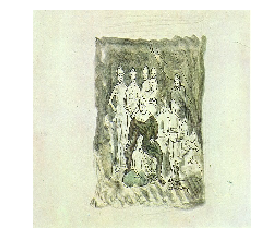

Painting by: picasso
Predicted: picasso Confidence Level: 100.0%


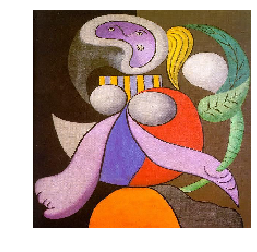

Painting by: picasso
Predicted: picasso Confidence Level: 100.0%


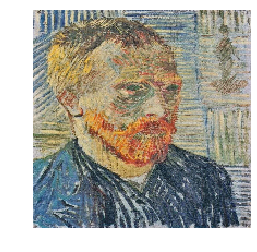

Painting by: gogh
Predicted: picasso Confidence Level: 100.0%


In [118]:
#index of painting
idd = 13
data = test_images[idd]
label = test_labels[idd]

#decode one hot encoding to get true label
index = np.argmax(label, axis=None, out=None)
show_image(data)

print('Painting by: '+ a[index])
make_single_prediction(data,200,200,1,3,model)
#------------------------------------------------------

data2 = picasso_excess_images[idd]
label2 = picasso_excess_labels[idd]
index2 = np.argmax(label2, axis=None, out=None)
show_image(data2)

print('Painting by: '+ a[index2])
make_single_prediction(data2,200,200,1,3,model)

#---------------------------------------------------------

data3 = gogh_excess_images[idd]
label3 = gogh_excess_labels[idd]
index3 = np.argmax(label3, axis=None, out=None)
show_image(data3)

print('Painting by: '+ a[index3])
make_single_prediction(data3,200,200,1,3,model)